In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader
import pandas as pd

In [71]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/baseline', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import create_sliding_windows, SequentialDeepONetDataset
from helper import load_model_experiment, load_model_experiment_deeponet, convert2dim, train_val_test_split, fit, compute_metrics_region

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [72]:
#------------------------------
# Load model (TRON and DeepONet)
#------------------------------
tron_model_path = 'analysis/baseline/single_branch/lstm_window_30.pth'

tron = load_model_experiment(tron_model_path).to(device)

print(tron)

# -- deeponet --
deeponet_model_path = 'analysis/baseline/single_branch/fnn_window_30.pth'

deeponet = load_model_experiment_deeponet(deeponet_model_path).to(device)

print(deeponet)

Loaded model from analysis/baseline/single_branch/lstm_window_30.pth
SequentialDeepONet(
  (branch_net): LSTM(
    (lstm): LSTM(12, 128, num_layers=4, batch_first=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=128, out_features=128, bias=True)
  )
  (trunk_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)
Loaded model from analysis/baseline/single_branch/fnn_window_30.pth
SequentialDeepONet(
  (branch_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=12, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_featu

In [73]:
# Load neutron monitoring data
input_data = np.load('data/neutron_data_22yrs.npy')
trunk = np.load('data/grid_points.npy')
target = np.load('data/dose_array.npy')

In [74]:
# Normalize trunk input
trunk[:, 0] = (trunk[:, 0] - np.min(trunk[:, 0])) / (np.max(trunk[:, 0]) - np.min(trunk[:, 0]))
trunk[:, 1] = (trunk[:, 1] - np.min(trunk[:, 1])) / (np.max(trunk[:, 1]) - np.min(trunk[:, 1]))

In [75]:
# window size
window_size = 30

In [76]:
from forecasting_analysis import create_windows_forecasting_with_index

dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = window_size, 0
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_data, target, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7641, 30, 12]) torch.Size([7641, 65341])
Validation set: torch.Size([365, 30, 12]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 12]) torch.Size([365, 65341])


## Gaussian Noise Injection

In [77]:
def inject_gaussian_white_original(
    X_test_orig,            # [B,W,S] ORIGINAL units; torch or np
    sigma_train,            # [S] per-sensor std (orig units)
    scaler_input,           # fitted MinMaxScaler
    alpha=0.5,              # noise level: sigma_noise = alpha * sigma_train
    prob_sensors=1.0,       # fraction of sensors to receive noise
    seed=42
):
    x_is_torch = isinstance(X_test_orig, torch.Tensor)
    dev  = X_test_orig.device if x_is_torch else None
    dtype= X_test_orig.dtype  if x_is_torch else None

    X = X_test_orig.detach().cpu().numpy() if x_is_torch else np.asarray(X_test_orig)
    sig = sigma_train.detach().cpu().numpy() if isinstance(sigma_train, torch.Tensor) else np.asarray(sigma_train)
    B, W, S = X.shape
    rng = np.random.default_rng(int(seed))

    # choose noisy sensors
    if prob_sensors < 1.0:
        mask = rng.random(S) < prob_sensors
    else:
        mask = np.ones(S, dtype=bool)

    # white Gaussian noise per (b,t,s), zero mean
    noise = rng.normal(loc=0.0, scale=alpha * sig[None, None, :], size=(B, W, S))
    noise[..., ~mask] = 0.0

    Xn = X + noise
    X2D = Xn.reshape(-1, S)
    Xn_scaled = scaler_input.transform(X2D).reshape(B, W, S)

    if x_is_torch:
        Xn_scaled = torch.from_numpy(Xn_scaled).to(device=dev, dtype=dtype)
    return Xn_scaled


In [78]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)[..., np.newaxis]
y_test_scaled  = scaler_target.transform(y_test)[..., np.newaxis]

In [79]:
## Compute training σ per sensor (original units)
# X_train is ORIGINAL units, shape [B_tr, W, S]
S = X_train.shape[-1]
sigma_train = X_train.reshape(-1, S).std(axis=0)  # per-sensor std from TRAIN set

In [80]:
from helper import fit, compute_metrics_region

In [81]:
def to_scalar(x) -> float:
    arr = np.asarray(x)
    if arr.ndim == 0:
        return float(arr)
    return float(arr.mean())

@torch.no_grad()
def eval_once(model, loader, device, scaler_target):
    model.eval()
    preds, tgts = fit(model, loader, device, scaler_target)
    return preds, tgts

def image_metrics(preds, tgts, lon_grid, lat_grid, extent=[-180,180,-90,90]):
    _, _, pred_img = convert2dim(preds)
    _, _, tgt_img  = convert2dim(tgts)
    l2, ssim = compute_metrics_region(pred_img, tgt_img, lon_grid, lat_grid, region_extent=extent)
    return l2, ssim, pred_img, tgt_img

In [82]:
alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
seed  = 1234

tron_L2_results = []
tron_SSIM_results = []
don_L2_results  = []
don_SSIM_results = []
for a in alpha:
    X_test_scaled_gauss = inject_gaussian_white_original(
        X_test_orig=X_test,            # ORIGINAL units
        sigma_train=sigma_train,       # per-sensor σ from train set (ORIGINAL units)
        scaler_input=scaler_input,     # your fitted MinMaxScaler
        alpha=a,
        prob_sensors=1.0,              # all sensors noisy (try 0.2 for 20%)
        seed=seed
        )

    # 2) Build dataloader
    test_dataset_gauss = SequentialDeepONetDataset(X_test_scaled_gauss, trunk, y_test_scaled)
    test_loader_gauss  = DataLoader(test_dataset_gauss, batch_size=16, shuffle=False)

    # 3) Evaluate TRON and DeepONet (your eval_once uses fit(...) under the hood)
    tron_pred_g, tron_tgt = eval_once(tron,     test_loader_gauss, device, scaler_target)
    don_pred_g,  don_tgt  = eval_once(deeponet, test_loader_gauss, device, scaler_target)

    # 4) Metrics (reuse your image helpers)
    lon_grid, lat_grid, _ = convert2dim(tron_pred_g)
    tron_L2, tron_SSIM, _, _ = image_metrics(tron_pred_g, tron_tgt, lon_grid, lat_grid)
    don_L2,  don_SSIM,  _, _ = image_metrics(don_pred_g,  don_tgt,  lon_grid, lat_grid)
    tron_L2_results.append(tron_L2)
    tron_SSIM_results.append(tron_SSIM)
    don_L2_results.append(don_L2)
    don_SSIM_results.append(don_SSIM)
    
# convert to arrays
tron_L2_results  = np.array(tron_L2_results)
tron_SSIM_results= np.array(tron_SSIM_results)
don_L2_results   = np.array(don_L2_results)
don_SSIM_results = np.array(don_SSIM_results)

Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.09581569
Mean SSIM: 0.9994244266754048
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.12846686
Mean SSIM: 0.9991445957332931
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.13054943
Mean SSIM: 0.9994214999274825
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.16437702
Mean SSIM: 0.9991413223016361
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.19775906
Mean SSIM: 0.999413850511006
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.23744574
Mean SSIM: 0.999129637587032
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.273035
Mean SSIM: 0.9993992593305863
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.32014424
Mean SSIM: 0.9991102368995013
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.351456
Mean SSIM: 0.9993788403324497
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.40725458
Mean SSIM: 0.9990825856049509
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.43143606
Mean SSIM: 0.9993523302364026
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.49718493
Mean

In [90]:
tron_L2_mean = tron_L2_results.mean(axis=1)
tron_SSIM_mean = tron_SSIM_results.mean(axis=1)
don_L2_mean  = don_L2_results.mean(axis=1)
don_SSIM_mean = don_SSIM_results.mean(axis=1)

tron_L2_std = tron_L2_results.std(axis=1)
tron_SSIM_std = tron_SSIM_results.std(axis=1)
don_L2_std  = don_L2_results.std(axis=1)
don_SSIM_std = don_SSIM_results.std(axis=1)

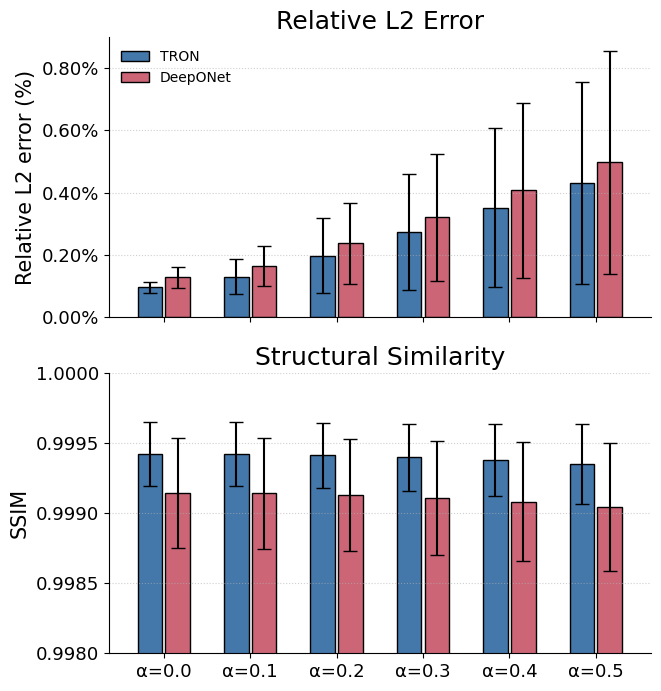

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FormatStrFormatter

# ---------------- spacing & style ----------------
group_stride = 1.4     # >1 for space BETWEEN groups
bar_width    = 0.40    # width of each bar
inner_gap    = 0.05    # gap BETWEEN the two bars in the same group

COLOR_TRON = '#4477AA'   # muted blue
COLOR_DON  = '#CC6677'   # warm salmon
EDGE = 'black'
LW   = 1.0

labels = [f"α={a}" for a in alpha]

# ---------------- positions ----------------
x = np.arange(len(labels))
centers = x * group_stride
offset  = (bar_width + inner_gap) / 2.0
x_tron  = centers - offset
x_don   = centers + offset

# ---------------- figure ----------------
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
fig.subplots_adjust(hspace=0.2)

# ===== (1) L2 subplot =====
ax = axes[0]
ax.bar(x_tron, tron_L2_mean, bar_width, yerr=tron_L2_std, capsize=5,
       label='TRON', color=COLOR_TRON, edgecolor=EDGE, linewidth=LW)
ax.bar(x_don,  don_L2_mean,  bar_width, yerr=don_L2_std,  capsize=5,
       label='DeepONet', color=COLOR_DON, edgecolor=EDGE, linewidth=LW)

ax.set_title('Relative L2 Error', fontsize=18)
ax.set_ylabel('Relative L2 error (%)', fontsize=15)
ax.yaxis.set_major_formatter(PercentFormatter(100))   # values already in %
ax.grid(axis='y', linestyle=':', linewidth=0.8, alpha=0.6)
ax.legend(loc='upper left', frameon=False)
ax.set_xticks(centers)
ax.set_xticklabels(labels, fontsize=15)
ax.margins(x=0.06)

# ===== (2) SSIM subplot =====
ax = axes[1]
ax.bar(x_tron, tron_SSIM_mean, bar_width, yerr=tron_SSIM_std, capsize=5,
       label='TRON', color=COLOR_TRON, edgecolor=EDGE, linewidth=LW)
ax.bar(x_don,  don_SSIM_mean,  bar_width, yerr=don_SSIM_std,  capsize=5,
       label='DeepONet', color=COLOR_DON, edgecolor=EDGE, linewidth=LW)

ax.set_title('Structural Similarity', fontsize=18)
ax.set_ylabel('SSIM', fontsize=15)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.set_ylim(0.998, 1.000)    # adjust zoom as needed
ax.grid(axis='y', linestyle=':', linewidth=0.8, alpha=0.6)
ax.set_xticks(centers)
ax.set_xticklabels(labels, fontsize=15)
ax.margins(x=0.06)

# remove the right and top spines for both subplots
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', labelsize=13)



plt.savefig('analysis/baseline/robustness.png', dpi=300)
plt.show()
